## 1. Carregando os dados de treino

Vamos iniciar a análise importando os dados da tarefa de classificação.


In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve


df_train = pd.read_csv('../classification_data/classification_train.csv')
df_test = pd.read_csv('../classification_data/classification_test.csv')


df_train.head()


,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


## 2. Visão geral do dataset

Aqui analisamos o volume de dados, tipos de variáveis e valores ausentes.


In [64]:
df_train.info()


df_train.describe(include='all')


df_train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      670 non-null    float64
 1   x2      670 non-null    float64
 2   target  670 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 15.8 KB


x1        0
x2        0
target    0
dtype: int64

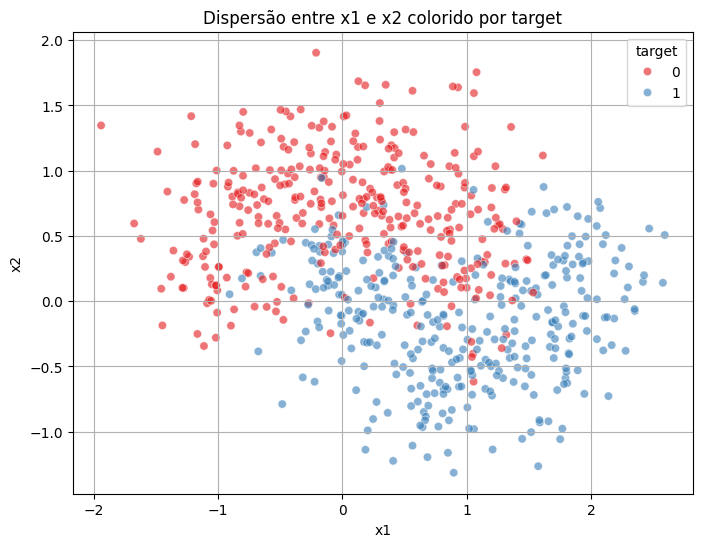

In [65]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_train, x='x1', y='x2', hue='target', palette='Set1', alpha=0.6)
plt.title('Dispersão entre x1 e x2 colorido por target')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

### Visualização da Dispersão entre x1 e x2

A dispersão entre `x1` e `x2` revela uma separação visual razoável entre as classes do `target`. Os pontos vermelhos representam a classe 0 e os azuis a classe 1.

Observamos que os dados da classe 0 tendem a ocupar regiões com valores maiores de `x2`, enquanto os da classe 1 se concentram mais abaixo do eixo horizontal. Isso sugere que a variável `x2` pode ser uma boa discriminante entre as classes, mas vamos conferir no gráfico de importância das variáveis.

Essa visualização ajuda a entender por que modelos simples como Random Forest e Gradient Boosting conseguem obter bons resultados mesmo com apenas duas variáveis numéricas.


##  Modelo de Classificação

In [66]:
# Separando variáveis preditoras e alvo
X_train = df_train[['x1', 'x2']]
y_train = df_train['target']

X_test = df_test[['x1', 'x2']]
y_test = df_test['target']


### Etapa 1: Comparação entre Modelos de Classificação

Diferentes modelos para o problema de classificação:

- **Random Forest**
- **Logistic Regression**
- **SVC (Support Vector Classifier)**
- **Gradient Boosting**

Avaliar os modelos pelas métricas `Precision`, `Recall`, `F1-Score`, `Accuracy` e `ROC AUC`.

> A métrica mais relevante neste contexto é o **F1-Score**, pois ela equilibra precisão e cobertura, importante em cenários com possíveis classes desbalanceadas.

Modelos baseados em árvores (Random Forest e Gradient Boosting) tendem a capturar melhor relações não lineares e interações entre variáveis, sendo fortes candidatos para testes mais profundos com tuning.



In [67]:

modelos = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

resultados = []

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    resultados.append({
        "Modelo": nome,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "ROC AUC": auc
    })

df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values("F1-Score", ascending=False)


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC AUC
3,Gradient Boosting,0.878788,0.878879,0.878788,0.878801,0.936951
2,SVC,0.875758,0.876562,0.875758,0.875766,0.946580
0,Random Forest,0.863636,0.863817,0.863636,0.863655,0.923665
1,Logistic Regression,0.833333,0.834105,0.833333,0.833344,0.915175


### Etapa 2 — Ajuste de Hiperparâmetros com GridSearchCV

Com base na performance anterior, seguimos com o **Gradient Boosting** e **SVC** para tunar seus hiperparâmetros. O objetivo é maximizar o **F1-Score**, equilibrando precisão e recall.


In [68]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='f1', n_jobs=-1)
grid_gb.fit(X_train, y_train)

print("Melhores parâmetros GB:", grid_gb.best_params_)

Melhores parâmetros GB: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [69]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(SVC(probability=True), param_grid_svc, cv=5, scoring='f1', n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Melhores parâmetros SVC:", grid_svc.best_params_)

Melhores parâmetros SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


### Avaliação final dos melhores modelos com hiperparâmetros otimizados

Reutilizamos os melhores hiperparâmetros encontrados via GridSearchCV para treinar os modelos finais de SVC e Gradient Boosting. Abaixo, avaliamos suas performances no conjunto de teste, utilizando as métricas: accuracy, precision, recall, F1-score e ROC AUC. Também visualizamos a matriz de confusão.


In [70]:
# Melhores parâmetros encontrados
melhores_parametros_gb = grid_gb.best_params_
melhores_parametros_svc = grid_svc.best_params_

# Treinamento final com os melhores parâmetros
modelo_gb = GradientBoostingClassifier(**melhores_parametros_gb, random_state=42)
modelo_gb.fit(X_train, y_train)

modelo_svc = SVC(**melhores_parametros_svc, probability=True, random_state=42)
modelo_svc.fit(X_train, y_train)



,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [71]:
# SVC
y_pred_svc = modelo_svc.predict(X_test)
y_prob_svc = modelo_svc.predict_proba(X_test)[:, 1]

# Gradient Boosting
y_pred_gb = modelo_gb.predict(X_test)
y_prob_gb = modelo_gb.predict_proba(X_test)[:, 1]


In [72]:
# Predições
y_pred_gb = modelo_gb.predict(X_test)
y_pred_svc = modelo_svc.predict(X_test)

# Probabilidades (para ROC AUC)
y_proba_gb = modelo_gb.predict_proba(X_test)[:, 1]
y_proba_svc = modelo_svc.predict_proba(X_test)[:, 1]

# Função para imprimir resultados
def imprimir_metricas(nome, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f" {nome}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC AUC:   {auc:.4f}\n")

# Resultados
imprimir_metricas("Gradient Boosting (otimizado)", y_test, y_pred_gb, y_proba_gb)
imprimir_metricas("SVC (otimizado)", y_test, y_pred_svc, y_proba_svc)

 Gradient Boosting (otimizado)
   Accuracy:  0.8758
   Precision: 0.8571
   Recall:    0.8944
   F1-Score:  0.8754
   ROC AUC:   0.9365

 SVC (otimizado)
   Accuracy:  0.8788
   Precision: 0.8667
   Recall:    0.8882
   F1-Score:  0.8773
   ROC AUC:   0.9372



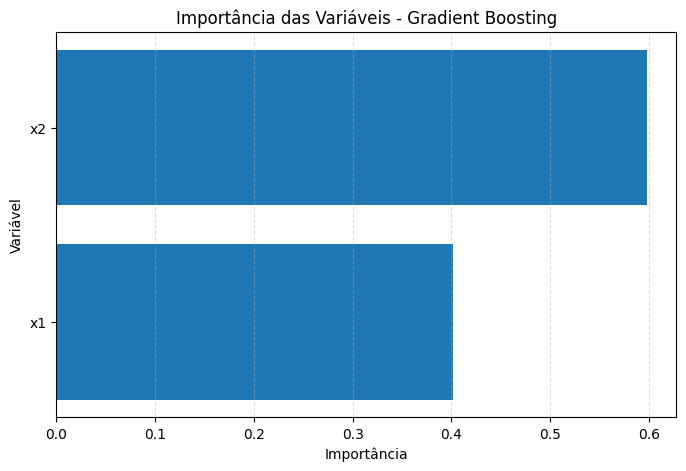

In [73]:
importancia = modelo_gb.feature_importances_
nomes_variaveis = X_train.columns

# Cria DataFrame e ordena
df_importancia = pd.DataFrame({
    'Variável': nomes_variaveis,
    'Importância': importancia
}).sort_values(by='Importância', ascending=False)

# Gráfico
plt.figure(figsize=(8, 5))
plt.barh(df_importancia['Variável'], df_importancia['Importância'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis - Gradient Boosting')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()

### Conclusão

Após aplicar otimização de hiperparâmetros via GridSearchCV, os modelos SVC e Gradient Boosting apresentaram bons desempenho na tarefa de classificação:

- **SVC (otimizado)** obteve a melhor performance geral, com:
  - Accuracy: 87.88%
  - F1-Score: 0.8773
  - ROC AUC: 0.9372

- **Gradient Boosting (otimizado)** também demonstrou performance muito próxima:
  - Accuracy: 87.58%
  - F1-Score: 0.8754
  - ROC AUC: 0.9365

Ambos os modelos são  eficazes, e a escolha final pode depender de fatores como tempo de treinamento, interpretabilidade ou escalabilidade.

---

### Importância das Variáveis

A análise de importância das variáveis no modelo Gradient Boosting revela que:

- As variáveis x1 e x2 são as únicas presentes na base e concentram toda a capacidade preditiva do modelo.

- Entre elas, x2 possui ligera maior contribuição, mas ambas são fundamentais para o desempenho da classificação.

- Isso reforça a efetividade do modelo em extrair valor preditivo mesmo com um número reduzido de variáveis.


